# NPCompare: a package for nonparametric density estimation and two populations comparison built on top of PyStan

<small>Marco Inacio (University of São Paulo/UFSCar)</small>

## Objective: comparing two populations

Given $Y_{i,1}, \ldots, Y_{i,n_i}$, i.i.d. with density $f_i$ where $i \in \{1,2\}$ index the population where the samples came from (and $n_1$ and $n_2$ are the sample sizes) and assume, for simplicity, that the support of such distributions is $[0, 1]$.

Then, let us consider the problem of comparing the two populations where the samples came from.

The solutions used so far involves hypothesis testing and/or Bayes Factors (i.e.: check if the populations are either the same or different). Here we propose something different: measuring the uncertainty regarding the distance between the two populations using a nonpametric a Bayesian method.

We measure such uncertainty by obtaining the posterior distribution of the integrated squared distance between $f_1$ and $f_2$:

$$
\mathbb{M}(f_1, f_2) = \int_0^1 (f_1(y) - f_2(y))^2 \mathrm{d}y
$$

## Package and implementation

To check the performance of the method, we decided to carry a simulation study and to apply it to a real medical dataset. We also decided to separate:

* The methods that implement such density and metric estimations went to a Python package, which is our main focus here.
* The application to simulated and real data (which themselves use the package), which were made available on repository on Github together with a Dockerfile and for which an article was submitted for peer review.

## Example

Below we have an example of calculating the metric $\mathbb{M}$ for PDF of a standard normal distribution $\varphi_0$ and the PDF of a normal distribution with mean 1 and standard deviation 1 $\varphi_1$:

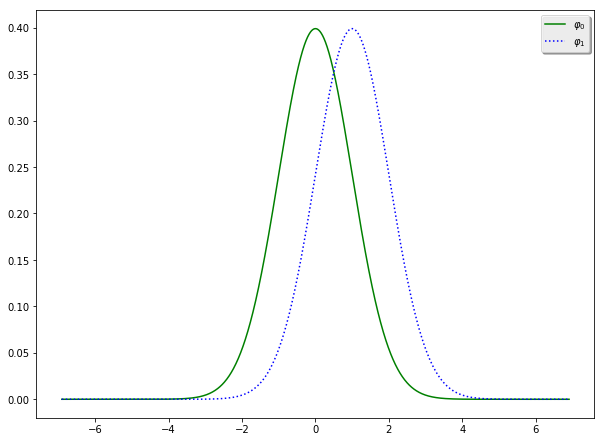

In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
from scipy.special import logit
import random

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 3*10/4)

np.random.seed(12)
random.seed(12)

pdf = stats.norm.pdf
gridsize = 1000
grid = logit(np.linspace(0, 1, gridsize))
pdf0 = pdf(grid, 0, 1)
pdf1 = pdf(grid, 1, 1)

ax = plt.subplot(111)
ax.plot(grid, pdf0, label=r'$\varphi_0$', ls="-", color="green")
ax.plot(grid, pdf1, label=r'$\varphi_1$', ls=":", color="blue")

legend = ax.legend(shadow=True, frameon=True, loc='best',
                   fancybox=True, borderaxespad=.5)

And we get

In [2]:
from scipy.integrate import quad
epsilon_0 = quad(lambda x: (stats.norm.pdf(x, 0)- stats.norm.pdf(x, 1))**2, -np.inf, np.inf)[0]
epsilon_0 

0.12479829408003376

As the value for $\mathbb{M}(\varphi_0, \varphi_1) = \epsilon_0$, which will be useful later for our analysis. Now let's delve a little bit into the statistical theory itself:

## Problem 1: obtaining samples from a nonparametric density estimation method

One way to obtain simulations for the posterior of $\mathbb{M}$, is to first obtain posterior simulations from $f_1$ and $f_2$. Here we use a nonparametric density estimation model which uses Fourier Series:

Given $\phi_i:[0, 1] \rightarrow [-\sqrt{2}, \sqrt{2}]$ where

$$\phi_i (x) = \begin{cases}
1 & \text{ if } i=0 \\
\sqrt{2} \sin(\pi (i+1) x) & \text{ if } i \in \{1, 3, 5, ...\} \\
\sqrt{2} \cos(\pi i x) & \text{ if } i \in \{2, 4, 6, ...\}
\end{cases}
$$

then under some conditions:

$$\left\| f - \sum_{i=1}^I \alpha_i \phi_i \right\| \rightarrow 0$$
as $I \rightarrow \infty$. Where
$$\alpha_i = \int_0^1 f \phi_i \mathrm{d}x$$

### Bayesian inference

So, in order to estimate the density, all we need is estimate $\alpha$ and estimate (or "choose a value") for $I$.

However, directly proceeding with the Bayesian inference by expanding $f$ would be a difficult problem since we have to define and work with priors in the constrained space where $f(y) \geq 0$ for all $y \in [0, 1]$.

#### Density function

So, instead, here we use the approach of sieve priors suggested by Scricciolo (2006). This approach automatically overcomes this issue by placing a prior directly on the coefficient vector $\beta$ of the Fourier series expansion of $\log(f)$ (instead of $f$) so that, conditionally on the threshold parameter (cutoff parameter) $I$, we have:

$$
f(y | I, \beta) = \frac{1}{g(\beta, I)} \exp \left \{ \sum_{i=1}^I \beta_i \phi_i(y) \right \}
$$

where $g$ is a normalizing **factor** such that

$$
g(\beta, I) = \int_0^1 \exp \left \{\sum_{i=1}^I \beta_i \phi_i(y) \right \}  \mathrm{d} y
$$

which is necessary in order to have $\int_0^1 f(y | I, \beta) \mathrm{d}y = 1$. Note that each $\beta_i$ lives in $\mathbb{R}$, which solves the constrained space problem.

As a drawback, we introduced the difficulty of calculating a normalizing factor when evaluating the likelihood function. This can be addressed by an additional patch to Stan that easily calculate unidimensional numerical integration (which by time of submission of this work, wasn't yet included in the official distribution of the software) or by using the ODE integrator of Stan (this is the current implementation of `NPCompare`).


#### Prior distribution

We have the following prior distribution for $\beta$:

$$
\begin{cases}
\beta_i \sim \text{Normal}(0, (i+1)^{-2p-1}) & \text{ if } i \in \{1, 3, 5, ...\} \\
\beta_i \sim \text{Normal}(0, i^{-2p-1})  & \text{ if } i \in \{2, 4, 6, ...\}
\end{cases}
$$

where $\beta_i$'s are independent from each other, $p$ is a strictly positive natural number and the normal distribution is parameterized in terms of mean and variance.

And a geometric prior distribution for the threshold parameter $I$:

$$
P(I = k) =
\frac{\exp \left \{ - \gamma k \right \}}
{ \sum_{i=1}^\infty \exp \left \{ - \gamma i \right \} }
$$

for all $k \in \mathbb{N}^*$. Here, $\gamma$ a is positive hyperparameter.

#### Maximum value for $I$
While on the definition of the model, we have $I \in \mathbb{N}^*$, this is not easily feasible on Stan, and therefore, we have to choose a maximum value for $I$. Note that `NPCompare` defaults to 10.


#### Example
Below we have an example of fitting a dataset to that density estimation method using the `NPCompare` package:

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bdc41e83c775b62dc927aac11b2ecfcb NOW.


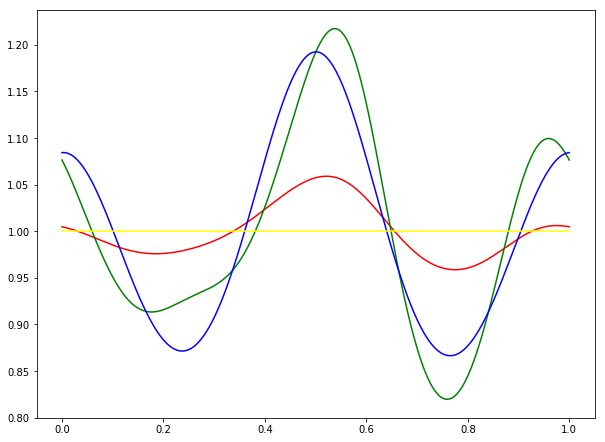

In [3]:
import npcompare as npc

#Example 1
obs = np.random.beta(1, 1, 100)
densobj1 = npc.EstimateBFS(obs, 5)
densobj1.sampleposterior(10000)

#evalualte estimated at a grid of points (needed to plot object)
densobj1.evalgrid()

#Plot estimated density:
p = densobj1.plot(color="red")

#Plot individual component of the mixture:
#That is, a fixed value for I
densobj1.plot(p, 4, color="green")
densobj1.plot(p, 3, color="blue")

#Plot true density:
p.plot(densobj1.egresults["gridpoints"],
       stats.beta.pdf(densobj1.egresults["gridpoints"], 1, 1),
       color="yellow")

Note that while the package uses PyStan, it does not require the user to have any knowledge of it nor of the Stan language itself.

Also, while the estimation method itself requires data to live in $[0, 1]$, the package can handle data outside of this range by means of a transformation: linear and logit and the package will automatically do the necessary calculations of Jacobian for plotting and calculating the posterior density.

See the examples below:

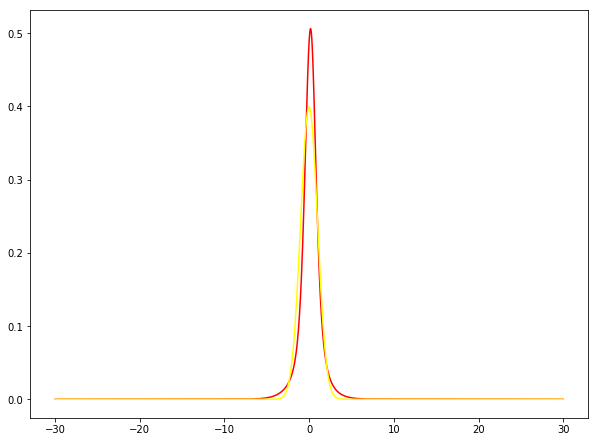

In [4]:
#Example 2
obs=np.random.normal(0, 1, 90)
densobj2 = npc.EstimateBFS(obs, 5, transformation="logit")
densobj2.sampleposterior(10000)

densobj2.evalgrid()
p = densobj2.plot(color="red")
p.plot(densobj2.egresults["gridpoints"],
       stats.norm.pdf(densobj2.egresults["gridpoints"], 0, 1), color="yellow")

In [5]:
#Example 3
obs3 = np.random.normal(0.5, 3.5, 110)
obs3 = obs3[obs3 > -3]
obs3 = obs3[obs3 < 3]
densobj3 = npc.EstimateBFS(obs3, transformation={"transf": "fixed",
                                                 "vmin": -3, "vmax": 3})
densobj3.sampleposterior(5000)

The package also accepts user-defined transformations, in which case one must supply a function that transforms $[0, 1]$ to the sample space, its inverse, and its log absolute derivative.

We now delve into theory of problem 2.

## Problem 2: obtaining samples the distance between the two distributions

There's a very simple method to obtain posterior simulations for $\mathbb{M}(f_1, f_2)|D$ once we have them for $f_1$ and $f_2$: assume independence between the two posterior distributions and randomly choose a simulation from each of them and calculate $M$ for them: you have one simulation for $M$!

And that's what the package allows us to do. Suppose, for instance that you already have the posterior simulations (e.g.: from a parametric model), then you can obtain simulations for $M$ using the class `Compare` like in the example bellow:

0 samples generated
100 samples generated
200 samples generated
300 samples generated
400 samples generated
500 samples generated
600 samples generated
700 samples generated
800 samples generated
900 samples generated
The expected value for M is 0.12451823493


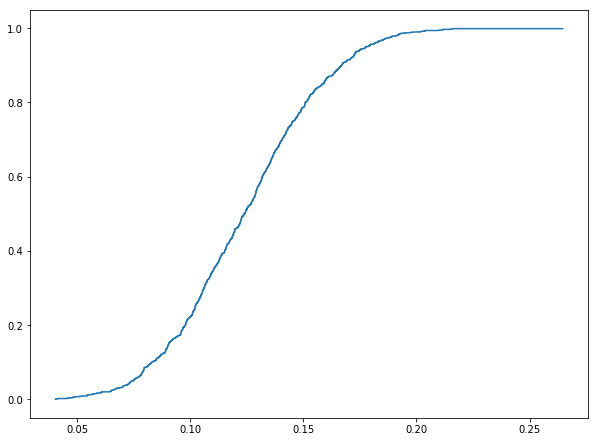

In [6]:
posterior1n = np.random.normal(0, 0.1, size=120)
posterior2n = np.random.normal(1, 0.1, size=100)

compn = npc.Compare(stats.norm.pdf, stats.norm.pdf,
                    posterior1n, posterior2n, lower=-300, upper=300)
compn.sampleposterior(1000)
print("The expected value for M is", compn.msamples.mean())
compn.plot()

The package is also able to construct a `Compare` object from two `EstimateBFS` objects, the pythonic way:

In [7]:
densobj1 = np.random.beta(1, 1, 100)
a = npc.EstimateBFS(densobj1)
a.sampleposterior(5000)

densobj2 = np.random.beta(0.9, 1.1, 110)
b = npc.EstimateBFS(densobj2)
b.sampleposterior(5000)

comp12 = npc.Compare.frombfs(a, b)
comp12.sampleposterior(900)

0 samples generated
100 samples generated
200 samples generated
300 samples generated
400 samples generated
500 samples generated
600 samples generated
700 samples generated
800 samples generated


So, how can we interpret such results? We could plot the value of $\epsilon_0$ along the ECDF of the posterior of $\mathbb{M}:

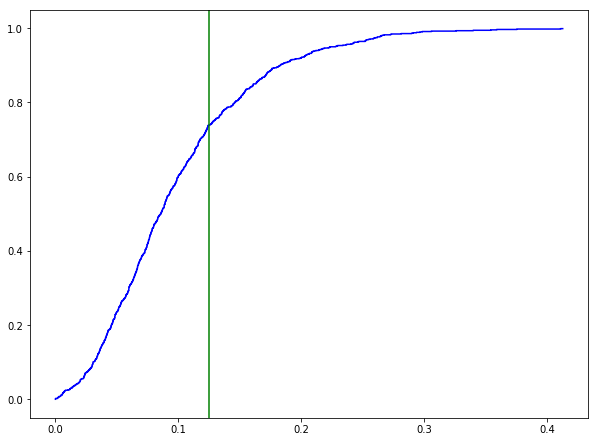

In [8]:
ax = comp12.plot(color="blue")
ax.axvline(epsilon_0, color="green")

Another possibility is to simply get $P(\mathbb{M}(f_1, f_2) \leq \epsilon_0 | D)$ which would gives us the probability that the distance between the two populations is less than or equal to the distance between $\varphi_0$ and $\varphi_1$:

In [9]:
(comp12.msamples <= epsilon_0).sum()/len(comp12)

0.73888888888888893

## Simulation Study

On a simulation study (with code available on [Github](https://github.com/randommm/two-sample-source-docker)), we have considered three "true models", and have generated 100 datasets from each of them and calculated $P(\mathbb{M}(f_1, f_2) \leq \epsilon_0 | D)$ for many combinations of such datasets, obtaining the following results (each combination of datasets gives us a green dot):

<img src="metric_simulated.png" alt="Dotplot" style="width: 700px; margin-left: 0" />

Where the horizontal orange
dashed line represents the mean of all points while the blue line represents the median. Note the sample size (of each dataset) is 50.

Since we known the "true models", we also know the "true distance M":
* Between true model 1 and true model 2 is approximately 0.118.
* Between true model 1 and true model 3 is approximately 1.280.
* Between true model 2 and true model 3 is approximately 0.881.

While, as we have seem:

In [10]:
epsilon_0

0.12479829408003376

## Real data

Here we used a dataset where the variable of interest measures the performance of each patient
on the Montreal cognitive assessment which was used by Cecato et al. [2016].

Here we have 3 groups of patients:
* AD represents the group of patients diagnosed with Alzheimer.
* MCD represents the group of patients diagnosed with a mild cognitive impairment.
* CG represents the control group.

We used the linear transformation of the package: S = (R − 50)/(107 − 50). Although the maximum and minimum possible values for this test are 0 and 107, we decided a priori, to assume
the minimum value to be 50, since it would be very unlikely for someone with such a low score
to even be placed to take such test.
For simplicity, we have also eliminated two missing data points from datasets. The following table presents some descriptive statistics:

<TABLE CELLPADDING=3 BORDER="1" Style="font-size: 14px">
<TR><TD ALIGN="CENTER">&nbsp;</TD>
<TD ALIGN="CENTER">Obs</TD>
<TD ALIGN="CENTER">Min</TD>
<TD ALIGN="CENTER">1st Qu</TD>
<TD ALIGN="CENTER">Median</TD>
<TD ALIGN="CENTER">Mean</TD>
<TD ALIGN="CENTER">3rd Qu</TD>
<TD ALIGN="CENTER">Max</TD>
<TD ALIGN="CENTER">SD</TD>
</TR>
<TR><TH ALIGN="CENTER"><SPAN  CLASS="textbf">MCD</SPAN></TH>
<TD ALIGN="CENTER">45</TD>
<TD ALIGN="CENTER">0.4035</TD>
<TD ALIGN="CENTER">0.6140</TD>
<TD ALIGN="CENTER">0.6842</TD>
<TD ALIGN="CENTER">0.6737</TD>
<TD ALIGN="CENTER">0.7719</TD>
<TD ALIGN="CENTER">0.8772</TD>
<TD ALIGN="CENTER">0.1163</TD>
</TR>
<TR><TH ALIGN="CENTER"><SPAN  CLASS="textbf">AD</SPAN></TH>
<TD ALIGN="CENTER">52</TD>
<TD ALIGN="CENTER">0.0351</TD>
<TD ALIGN="CENTER">0.3421</TD>
<TD ALIGN="CENTER">0.5263</TD>
<TD ALIGN="CENTER">0.4716</TD>
<TD ALIGN="CENTER">0.6272</TD>
<TD ALIGN="CENTER">0.8070</TD>
<TD ALIGN="CENTER">0.2042</TD>
</TR>
<TR><TH ALIGN="CENTER"><SPAN  CLASS="textbf">CG</SPAN></TH>
<TD ALIGN="CENTER">39</TD>
<TD ALIGN="CENTER">0.5614</TD>
<TD ALIGN="CENTER">0.7632</TD>
<TD ALIGN="CENTER">0.8596</TD>
<TD ALIGN="CENTER">0.8376</TD>
<TD ALIGN="CENTER">0.9123</TD>
<TD ALIGN="CENTER">1.0000</TD>
<TD ALIGN="CENTER">0.0941</TD>
</TR>
</TABLE>

In the following plot we have the estimated density using `npcompare.EstimateBFS`:

<img src="density_real.png" alt="Dotplot" style="width: 700px; margin-left: 0" />

And finally, in the following plot we have $P(M(f_1, f_2 \leq \epsilon)$ (the ECDF of posterior simulations of $\mathbb{M}$) that we obtained with `npcompare.Compare`:

<img src="metric_real.png" alt="Dotplot" style="width: 700px; margin-left: 0" />


We can clearly see that the estimated distance between the population of patients diagnosed with Alzheimer and the "control population" is greater than the estimated distance of population of patients diagnosed with a mild cognitive impairment and the "control population".

Therefore, the method clearly returned sensible results on both simulated and real datasets.

## Additional details about the package

* Also includes a class `EstimateLindleyBFS` that places a Lindley prior on $\mathbb{M}$, that is: $P(\mathbb{M}(f_1, f_2)) > 0$.
* Fully [documented](http://npcompare.marcoinacio.com) (or at least it should be).
* Includes unit tests and `.travis.yml`.

## Possibilities for future research


* Relaxing the assumption of independence between the two distributions and/or check its consequences.
* Check the assumption of decreasing posterior for $I$.
* The choice of the parameters of the prior (study of sensibility? Cross validation or data splitting?).
* Choice of $\epsilon$ and maybe another metric for the distance between $f_1$ and $f_2$: decision theory?
* Study of the properties of the density estimator on the boundaries and of the impact of the choice of the transformation function.

## References

* Juliana Francisco Cecato, José Eduardo Martinelli, Rafael Izbicki, Mônica Sanches Yassuda, and Ivan Aprahamian. A subtest analysis of the Montreal cognitive assessment (moca): which subtests can best discriminate between healthy controls, mild cognitive impairment and alzheimer’s disease? International Psychogeriatrics, 28(5):825–832, 005 2016.
* Catia Scricciolo. Convergence rates for Bayesian density estimation of infinite-dimensional exponential families. The Annals of Statistics, 34(6):2897–2920, 2006.